In [16]:
import gymnasium as gym

from stable_baselines3 import SAC
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()

In [17]:
envs = ["CartPole-v0", "CartPole-v1", "MountainCar-v0", "MountainCarContinuous-v0","Pendulum-v1", "Acrobot-v1"] # cant use discrete environments with SAC
envs_continuous = ["MountainCarContinuous-v0", "Pendulum-v1"] #mountaincar is very long to run

ENV_NAME = envs_continuous[1]
env = gym.make(ENV_NAME)


In [18]:
def evaluate_model(model, env, n_episodes=10):
    """
    Evaluate a RL model
    :param model: (BaseAlgorithm) the RL agent
    :param env: (gym.Env) the gym environment
    :param n_episodes: (int) number of episodes to evaluate
    :return: (float) mean reward
    """
    episode_rewards = []
    for _ in range(n_episodes):
        obs, _ = env.reset()  # Unpack the tuple returned by env.reset()
        episode_reward = 0
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)  # Unpack the tuple returned by env.step()
            done = terminated or truncated
            episode_reward += reward
        episode_rewards.append(episode_reward)
    return episode_rewards

In [19]:
hyperparams = {'learning_rate': 0.0007083063041887058, 'batch_size': 64, 'gamma': 0.9268136976134769, 'ent_coef': 71.07019482047461, 'gradient_steps': -1, 'learning_starts': 0, 'tau': 0.003432761512376074, 'train_freq': 10, 'buffer_size': 1000000,
               "policy_kwargs": {'net_arch': [64, 64]}}

def search_ent_coef(env, ent_coefs, N_EPISODES, N_SEEDS, N_TIMESTEPS):
    mean_rewards = np.zeros_like(ent_coefs)
    std_rewards = np.zeros_like(ent_coefs)
    mean_rewards_over_episodes = np.zeros((len(ent_coefs), N_EPISODES))
    std_rewards_over_episodes = np.zeros((len(ent_coefs), N_EPISODES))

    for coef_idx, coef in enumerate(ent_coefs):
        print(coef_idx)
        buff = np.zeros(N_SEEDS)
        buff_over_episodes = np.zeros((N_SEEDS, N_EPISODES))
        hyperparams["ent_coef"] =  coef
        model = SAC("MlpPolicy", env, verbose=0, **hyperparams)
        model.learn(total_timesteps=N_TIMESTEPS)
        for i in range(N_SEEDS):
            episode_rewards = evaluate_model(model, env, n_episodes=N_EPISODES)
            buff[i] = np.mean(episode_rewards)
            buff_over_episodes[i] = episode_rewards

        mean_rewards_over_episodes[coef_idx] = np.mean(buff_over_episodes, axis=0)
        std_rewards_over_episodes[coef_idx] = np.std(buff_over_episodes, axis=0)
        mean_rewards[coef_idx] = np.mean(buff)
        std_rewards[coef_idx] = np.std(buff)


    return mean_rewards, std_rewards, mean_rewards_over_episodes, std_rewards_over_episodes



In [20]:
coefs = [1e-3, 1e-2, 1e-1, 1, 10, 100]
N_SEEDS = 3
N_EPISODES = 500
N_TIMESTEPS = 10000

In [21]:
mean_rewards, std_rewards, mean_rewards_over_episodes, std_rewards_over_episodes = search_ent_coef(env, coefs, N_EPISODES, N_SEEDS, N_TIMESTEPS)
np.savetxt(f'./values/mean_[{coefs[0]}-{coefs[-1]}]_{N_SEEDS}_{N_EPISODES}_{N_TIMESTEPS}_{ENV_NAME}', mean_rewards, delimiter=',')
np.savetxt(f'./values/std_[{coefs[0]}-{coefs[-1]}]_{N_SEEDS}_{N_EPISODES}_{N_TIMESTEPS}_{ENV_NAME}', std_rewards, delimiter=',')
np.savetxt(f'./values/mean_over_episodes_[{coefs[0]}-{coefs[-1]}]_{N_SEEDS}_{N_EPISODES}_{N_TIMESTEPS}_{ENV_NAME}', mean_rewards_over_episodes, delimiter=',')
np.savetxt(f'./values/std_over_episodes_[{coefs[0]}-{coefs[-1]}]_{N_SEEDS}_{N_EPISODES}_{N_TIMESTEPS}__{ENV_NAME}', std_rewards_over_episodes, delimiter=',')

0
1
2
3
4
5


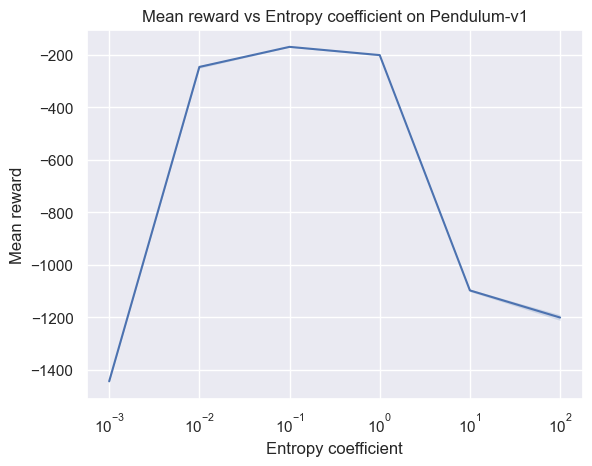

In [22]:
# mean_rewards = np.loadtxt(f'./values/mean_[{coefs[0]}-{coefs[-1]}]_{N_SEEDS}_{N_EPISODES}_{N_TIMESTEPS}_{ENV_NAME}', delimiter=',')
# std_rewards = np.loadtxt(f'./values/std_[{coefs[0]}-{coefs[-1]}]_{N_SEEDS}_{N_EPISODES}_{N_TIMESTEPS}_{ENV_NAME}', delimiter=',')
# mean_rewards_over_episodes = np.loadtxt(f'./values/mean_over_episodes_[{coefs[0]}-{coefs[-1]}]_{N_SEEDS}_{N_EPISODES}_{N_TIMESTEPS}_{ENV_NAME}', delimiter=',')
# std_rewards_over_episodes = np.loadtxt(f'./values/std_over_episodes_[{coefs[0]}-{coefs[-1]}]_{N_SEEDS}_{N_EPISODES}_{N_TIMESTEPS}__{ENV_NAME}', delimiter=',')




plt.plot(coefs, mean_rewards, label="Mean reward")
plt.fill_between(coefs, mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2, label="Std reward")

plt.xlabel("Entropy coefficient")
plt.ylabel("Mean reward")
plt.title(f"Mean reward vs Entropy coefficient on {ENV_NAME}")
plt.xscale("log")

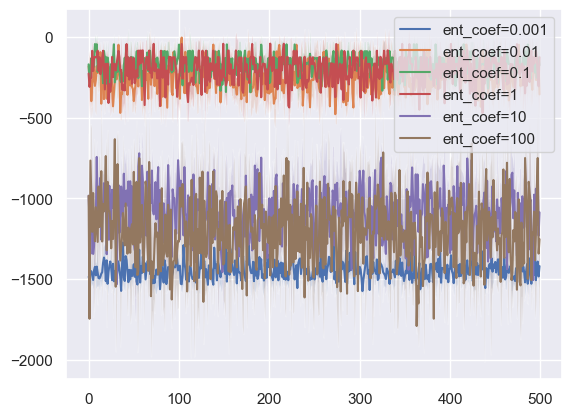

In [23]:
dom_episodes = range(N_EPISODES)

for i in range(len(coefs)):
  plt.plot(dom_episodes, mean_rewards_over_episodes[i], label=f"ent_coef={coefs[i]}")
  plt.fill_between(dom_episodes, mean_rewards_over_episodes[i] - std_rewards_over_episodes[i], mean_rewards_over_episodes[i] + std_rewards_over_episodes[i], alpha=0.2)

plt.legend(loc='upper right')
plt.show()

In [24]:

from gym.wrappers import RecordVideo
import os


coef = 1e-1
hyperparams = {"ent_coef": coef}
model = SAC("MlpPolicy", env, verbose=0, **hyperparams)
model.learn(total_timesteps=N_TIMESTEPS)


In [25]:
import time

def evaluate_and_record(model, env_id, video_folder="videos", n_episodes=1):
    env = gym.make(env_id, render_mode="rgb_array")
    env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: True)

    obs, _ = env.reset()
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated = env.step(action)
            done = terminated or truncated
    print(f"Video saved to {os.path.abspath(video_folder)}")



evaluate_and_record(model, env_id=ENV_NAME, video_folder="videos")

C:\Users\matya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\matya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\wrappers\record_video.py:78: UserWarning: WARN: Overwriting existing videos at c:\Users\matya\OneDrive\Bureau\RL\EE-568-Deep-RL-project\algorithms\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video saved to c:\Users\matya\OneDrive\Bureau\RL\EE-568-Deep-RL-project\algorithms\videos


In [26]:
import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

def make_env(env_id, render_mode=None):
    def _init():
        env = gym.make(env_id, render_mode=render_mode)
        env = Monitor(env)
        return env
    return _init

# Create environment
env = DummyVecEnv([make_env(ENV_NAME, render_mode="human")])

try:
    # Option 1: Load with environment verification (if model was saved with env)
    # model = TD3.load("best_model_mountain_car.zip", env=env)
    
    # Option 2: Load without verification then set env
    model.set_env(env)
    
    # Run the model
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        env.render()


finally:
    env.close()
